Notebook purpose

- Sense-check and explore calculated account balances

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [33]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy/entropy_{SAMPLE}.parquet'
fp = 's3://3di-project-entropy/entropy_XX7.parquet'

df = aws.read_parquet(fp)
print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))

Rows: 6,791,894
Users: 2357


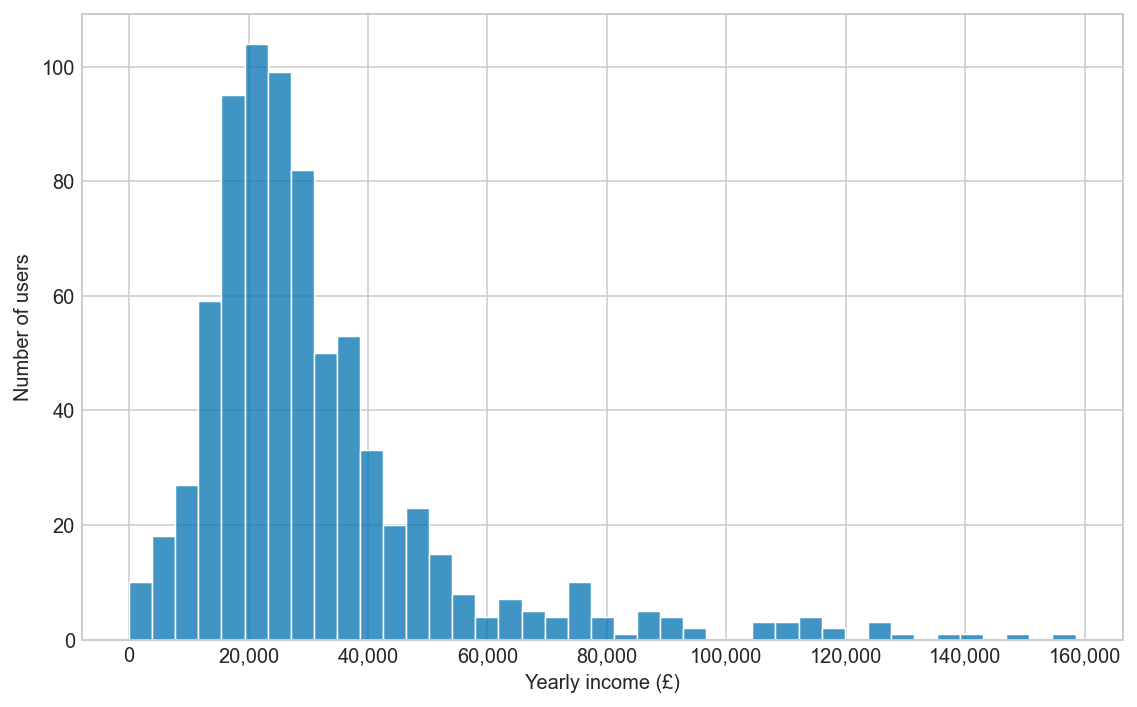

In [54]:
figs.user_income_hist(df, write=False)

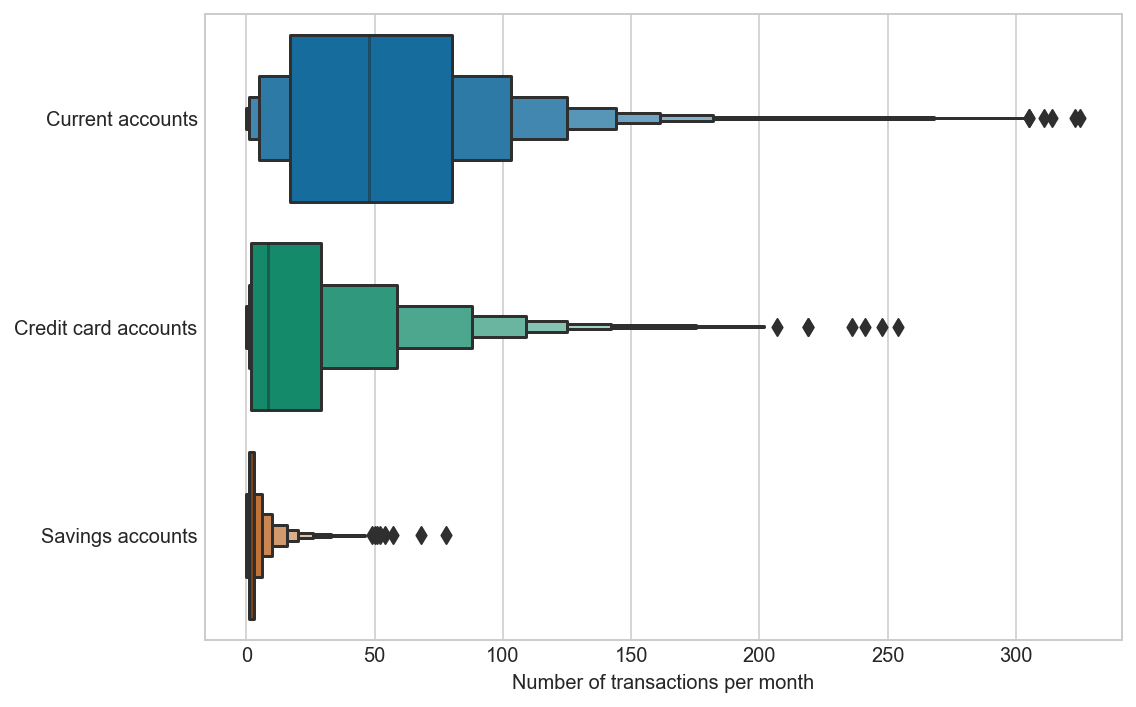

In [58]:
figs.num_txns_by_account_type(df, write=False)

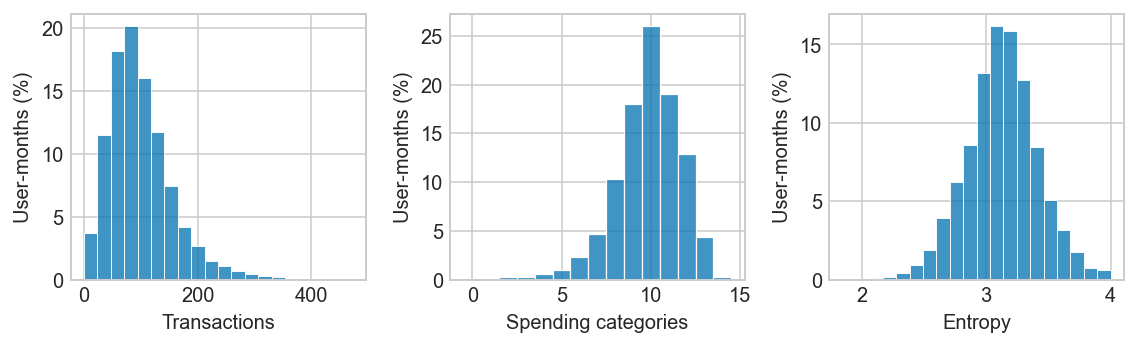

In [61]:
figs.txns_distrs(df, write=False)

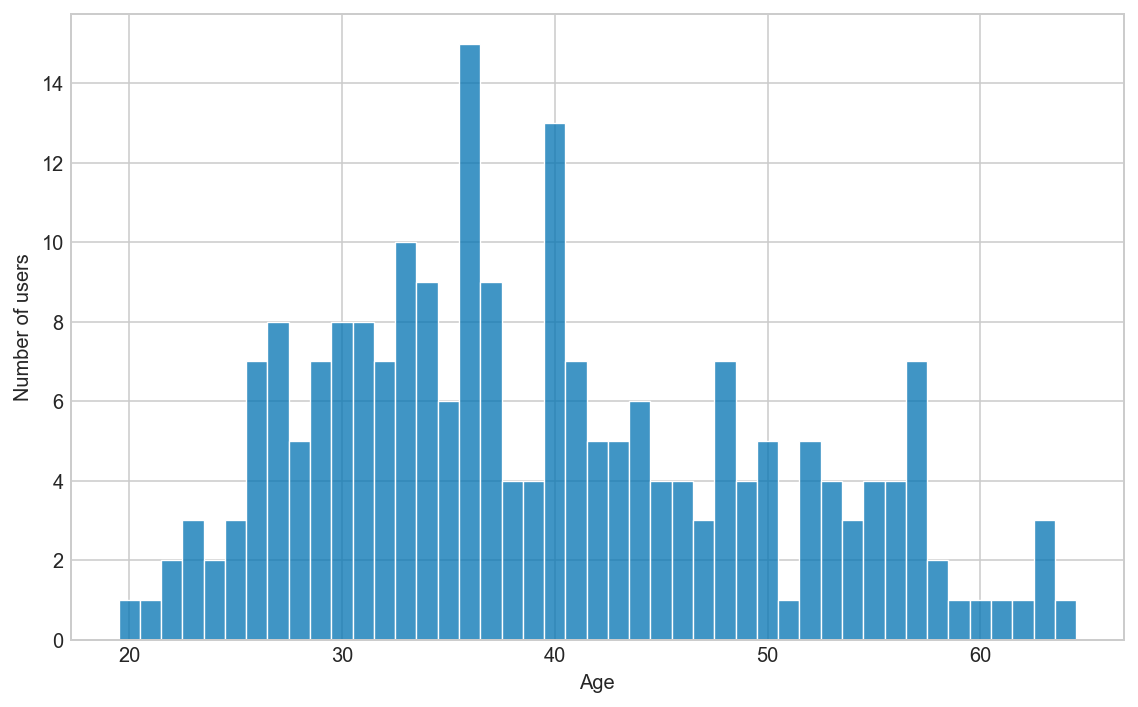

In [32]:
figs.user_age_hist(df, write=False)